In [507]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import seaborn as sns

np.random.seed(42)

In [510]:
historical_data_M = pd.DataFrame({
    'Name': ['Aaron', 'Bob', 'Charlie', 'David', 'Evan', 'Frank', 'George', 'Henry', 'Ilai', 'Jack'],
    'Gender': ['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M'],
    'Age': np.random.randint(25, 45, 10),
    'Education': np.random.choice(['Bachelors', 'Masters', 'PhD'], 10, p=[0.3, 0.3, 0.4]),
    'Experience': np.random.randint(3, 12, 10),
    'Hired': [1, 1, 0, 0, 1, 0, 1, 0, 1, 0]
})

historical_data_F = pd.DataFrame({
    'Name': ['Alice', 'Bonnie', 'Cindy', 'Daria', 'Eva', 'Grace', 'Hanna', 'Ivy', 'Julia', 'Zoe'],
    'Gender': ['F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F', 'F'],
    'Age': np.random.randint(25, 35, 10),
    'Education': np.random.choice(['Bachelors', 'Masters', 'PhD'], 10, p=[0.4, 0.4, 0.2]),
    'Experience': np.random.randint(3, 12, 10),
    'Hired': [1, 1, 0, 0, 1, 0, 1, 0, 1, 0]
})

historical_data_U = pd.concat([historical_data_F, historical_data_M], axis=0)
invalid_exp_mask = historical_data_U['Age'] <= historical_data_U['Experience'] + 18
historical_data_U['ModExperience'] = historical_data_U['Age'].apply(lambda x: x // 4)

new_applicants = pd.DataFrame({
    'Name': ['Liam', 'Mia', 'Noah', 'Olivia', 'Paul', 'Quinn', 'Ruth', 'Steve', 'Tina', 'Uma'],
    'Gender': ['M', 'F', 'M', 'F', 'M', 'F', 'F', 'M', 'F', 'F'],
    'Age': np.random.randint(25, 45, 10),
    'Education': np.random.choice(['Bachelors', 'Masters', 'PhD'], 10, p=[0.4, 0.3, 0.3]),
    'Experience': np.random.randint(3, 12, 10)
})

male_mask = new_applicants['Gender'] == 'M'
education_mask = new_applicants['Education'] == 'Phd'
new_applicants['ModAge'] = new_applicants['Age'].where(male_mask & education_mask, new_applicants['Age'] + 5)
new_applicants['ModExperience'] = new_applicants['Experience'].where(education_mask, new_applicants['Experience'] + 1)

print("New Applicants:\n", new_applicants)

New Applicants:
      Name Gender  Age  Education  Experience  ModAge  ModExperience
0    Liam      M   32  Bachelors          11      37             12
1     Mia      F   40    Masters           9      45             10
2    Noah      M   37  Bachelors          11      42             12
3  Olivia      F   42  Bachelors          10      47             11
4    Paul      M   39  Bachelors           4      44              5
5   Quinn      F   37  Bachelors           3      42              4
6    Ruth      F   33        PhD           9      38             10
7   Steve      M   39        PhD           9      44             10
8    Tina      F   37    Masters          10      42             11
9     Uma      F   25        PhD           7      30              8


In [511]:
historical_data_U = historical_data_U.drop(['Experience'], axis=1).rename({'ModExperience': 'Experience'}, axis=1)
new_applicants = new_applicants.drop(['Age', 'Experience'], axis=1).rename(
    {'ModAge': 'Age', 'ModExperience': 'Experience'}, axis=1)
new_applicants

,Name,Gender,Education,Age,Experience
0,Liam,M,Bachelors,37,12
1,Mia,F,Masters,45,10
2,Noah,M,Bachelors,42,12
3,Olivia,F,Bachelors,47,11
4,Paul,M,Bachelors,44,5
5,Quinn,F,Bachelors,42,4
6,Ruth,F,PhD,38,10
7,Steve,M,PhD,44,10
8,Tina,F,Masters,42,11
9,Uma,F,PhD,30,8


In [512]:
X_train = pd.get_dummies(historical_data_U.drop(columns=['Name', 'Hired', 'Gender']), drop_first=True)
y_train = historical_data_U['Hired']

model = LogisticRegression()
model.fit(X_train, y_train)

X_new = pd.get_dummies(new_applicants.drop(columns=['Name', 'Gender']), drop_first=True)

new_applicants['Hiring_Probability'] = model.predict_proba(X_new)[:, 1]
print("New Applicants with Hiring Probability:\n", new_applicants)

New Applicants with Hiring Probability:
      Name Gender  Education  Age  Experience  Hiring_Probability
0    Liam      M  Bachelors   37          12            0.868395
1     Mia      F    Masters   45          10            0.499428
2    Noah      M  Bachelors   42          12            0.757988
3  Olivia      F  Bachelors   47          11            0.427116
4    Paul      M  Bachelors   44           5            0.018210
5   Quinn      F  Bachelors   42           4            0.012377
6    Ruth      F        PhD   38          10            0.760936
7   Steve      M        PhD   44          10            0.565526
8    Tina      F    Masters   42          11            0.756752
9     Uma      F        PhD   30           8            0.725078


Text(0.5, 1.0, 'Proportion of Hires by Gender')

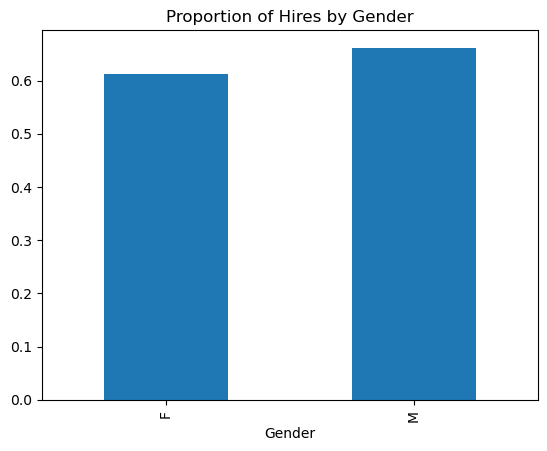

In [513]:
new_applicants.groupby('Gender').Hiring_Probability.median().plot.bar()
plt.title("Proportion of Hires by Gender")

In [514]:
def human_in_the_loop_decision(probability, gender):
    if gender == 'M':
        return probability * 0.9
    return probability


new_applicants['HITL_Hiring_Probability'] = new_applicants.apply(
    lambda row: human_in_the_loop_decision(row['Hiring_Probability'], row['Gender']), axis=1
)

new_applicants['Final_Decision'] = new_applicants['HITL_Hiring_Probability'] > 0.5
new_applicants

,Name,Gender,Education,Age,Experience,Hiring_Probability,HITL_Hiring_Probability,Final_Decision
0,Liam,M,Bachelors,37,12,0.868395,0.781556,True
1,Mia,F,Masters,45,10,0.499428,0.499428,False
2,Noah,M,Bachelors,42,12,0.757988,0.682189,True
3,Olivia,F,Bachelors,47,11,0.427116,0.427116,False
4,Paul,M,Bachelors,44,5,0.018210,0.016389,False
5,Quinn,F,Bachelors,42,4,0.012377,0.012377,False
6,Ruth,F,PhD,38,10,0.760936,0.760936,True
7,Steve,M,PhD,44,10,0.565526,0.508973,True
8,Tina,F,Masters,42,11,0.756752,0.756752,True
9,Uma,F,PhD,30,8,0.725078,0.725078,True


<Axes: title={'center': 'HIL - Proportion of Hires by Gender'}, xlabel='Gender'>

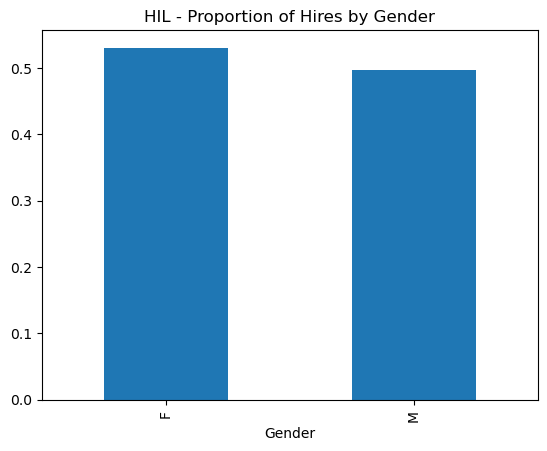

In [515]:
plt.title("HIL - Proportion of Hires by Gender")
new_applicants.groupby('Gender').HITL_Hiring_Probability.mean().plot.bar()

<Axes: title={'center': 'HIL - Count of Hires per Gender'}, xlabel='Gender'>

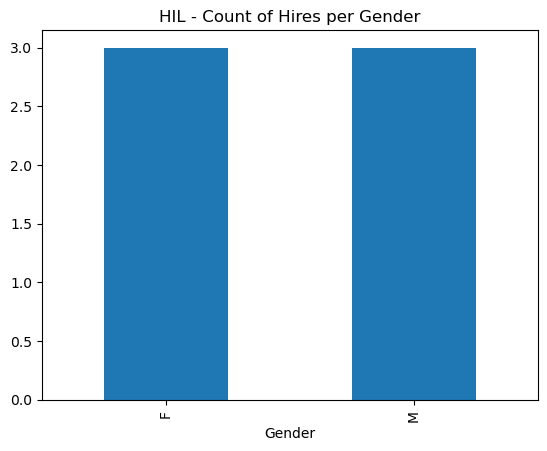

In [516]:
plt.title("HIL - Count of Hires per Gender")
new_applicants.groupby('Gender').Final_Decision.sum().plot.bar()

### HIL layer made the hiring probabilities more balanced! yay! 

<Axes: title={'center': 'HIL - Education count of hired'}, xlabel='Education'>

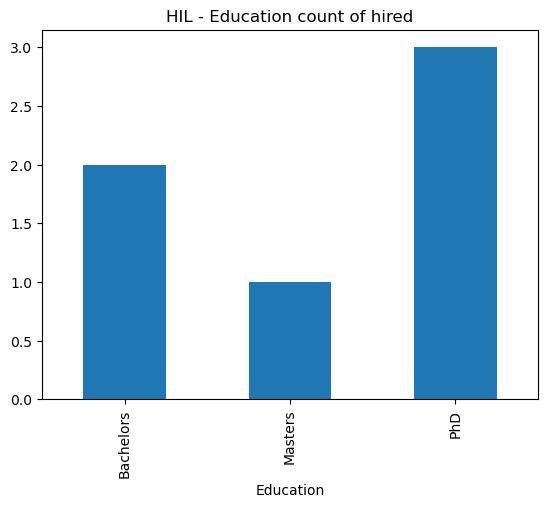

In [517]:
plt.title("HIL - Education count of hired")
new_applicants.groupby('Education').Final_Decision.sum().plot.bar()

<Axes: title={'center': 'HIL - Final Decision mean age \n(False = Rejected, True = Hired)'}, xlabel='Final_Decision'>

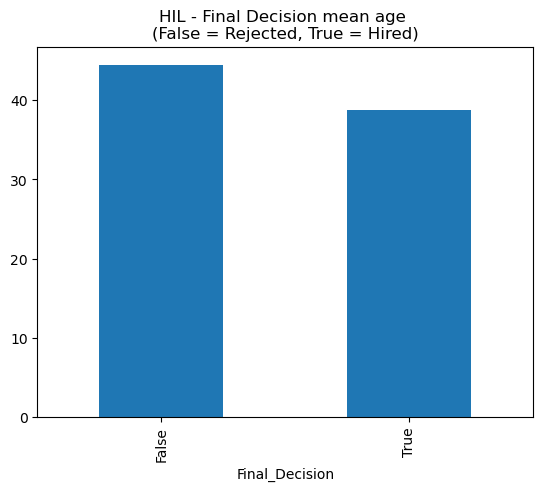

In [518]:
plt.title("HIL - Final Decision mean age \n(False = Rejected, True = Hired)")
new_applicants.groupby('Final_Decision').Age.mean().plot.bar()

### No need to be concerned about age bias! wonderfully HIL

In [546]:
n_samples_M = 100
genders_M = ['M'] * n_samples_M
educations_M = np.random.choice(['Bachelors', 'Masters', 'PhD'], n_samples_M, p=[0.3, 0.2, 0.5])
experiences_M = np.random.randint(3, 12, n_samples_M)

mean_age_M = 35
std_dev_M = 7
ages_M = np.random.normal(loc=mean_age_M, scale=std_dev_M, size=n_samples_M)
ages_M = np.clip(ages_M, 25, 55).astype(int)

new_applicants_BIAS_M = pd.DataFrame({
    'Gender': ['M'] * n_samples_M,
    'Age': ages_M,
    'Education': educations_M,
    'Experience': experiences_M,
})

n_samples_F = 50
genders_F = ['F'] * n_samples_F
educations_F = np.random.choice(['Bachelors', 'Masters', 'PhD'], n_samples_F, p=[0.5, 0.4, 0.1])
experiences_F = np.random.randint(3, 12, n_samples_F)

mean_age_F = 35
std_dev_f = 7
ages_F = np.random.normal(loc=mean_age_F, scale=std_dev_f, size=n_samples_F)
ages_F = np.clip(ages_F, 25, 45).astype(int)

new_applicants_BIAS_F = pd.DataFrame({
    'Gender': genders_F,
    'Age': ages_F,
    'Education': educations_F,
    'Experience': experiences_F,
})

new_applicants_BIAS = pd.concat([new_applicants_BIAS_M, new_applicants_BIAS_F], axis=0)

print("New Applicants:\n", new_applicants_BIAS)
new_applicants_BIAS.Age.describe()

New Applicants:
    Gender  Age  Education  Experience
0       M   43    Masters           4
1       M   42        PhD           9
2       M   39        PhD           6
3       M   27        PhD           3
4       M   28        PhD           6
..    ...  ...        ...         ...
45      F   35    Masters           8
46      F   26    Masters           3
47      F   43    Masters           9
48      F   39  Bachelors           5
49      F   32  Bachelors           7

[150 rows x 4 columns]


count    150.000000
mean      34.106667
std        6.230631
min       25.000000
25%       29.000000
50%       34.000000
75%       39.000000
max       46.000000
Name: Age, dtype: float64

In [547]:
X_new_BIAS = pd.get_dummies(new_applicants_BIAS.drop(columns=['Gender'], axis=1), drop_first=True)
new_applicants_BIAS['Hiring_Probability'] = model.predict_proba(X_new_BIAS)[:, 1]


def human_in_the_loop_decision(probability, gender):
    if gender == 'M':
        return probability * 0.88
    return probability


new_applicants_BIAS['HITL_Hiring_Probability'] = new_applicants_BIAS.apply(
    lambda row: human_in_the_loop_decision(row['Hiring_Probability'], row['Gender']), axis=1
)

mean_p = new_applicants_BIAS['Hiring_Probability'].quantile(.5)
new_applicants_BIAS['Final_Decision'] = new_applicants_BIAS['HITL_Hiring_Probability'] > mean_p
new_applicants_BIAS

,Gender,Age,Education,Experience,Hiring_Probability,HITL_Hiring_Probability,Final_Decision
0,M,43,Masters,4,0.020937,0.018425,False
1,M,42,PhD,9,0.467929,0.411778,True
2,M,39,PhD,6,0.147822,0.130083,False
3,M,27,PhD,3,0.115697,0.101813,False
4,M,28,PhD,6,0.471922,0.415292,True
...,...,...,...,...,...,...,...
45,F,35,Masters,8,0.526913,0.526913,True
46,F,26,Masters,3,0.119028,0.119028,False
47,F,43,Masters,9,0.402667,0.402667,True
48,F,39,Bachelors,5,0.037607,0.037607,False


Text(0.5, 1.0, 'Proportion of Hires by Gender Before HIL')

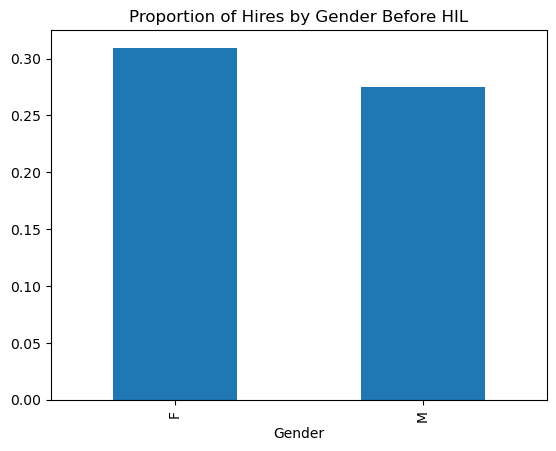

In [548]:
new_applicants_BIAS.groupby('Gender').Hiring_Probability.median().plot.bar()
plt.title("Proportion of Hires by Gender Before HIL")

### We can observe the frequency of elder ages among rejection is higher then hires. Can we infer the model prefers younger candidates and tends to reject older ?

<Axes: xlabel='Age', ylabel='Frequency'>

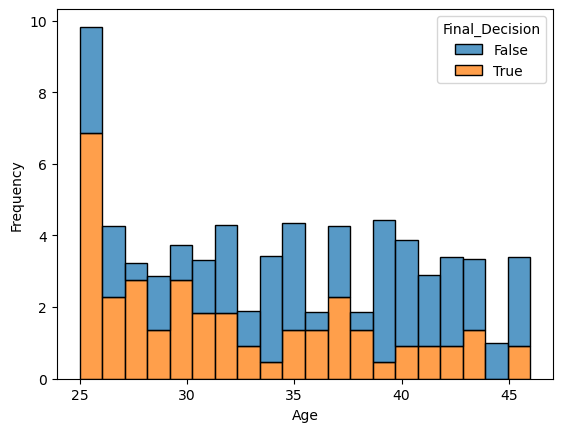

In [559]:
sns.histplot(data=new_applicants_BIAS, x="Age", hue="Final_Decision", multiple="stack", stat="frequency", bins=20)

<Axes: xlabel='Age', ylabel='Density'>

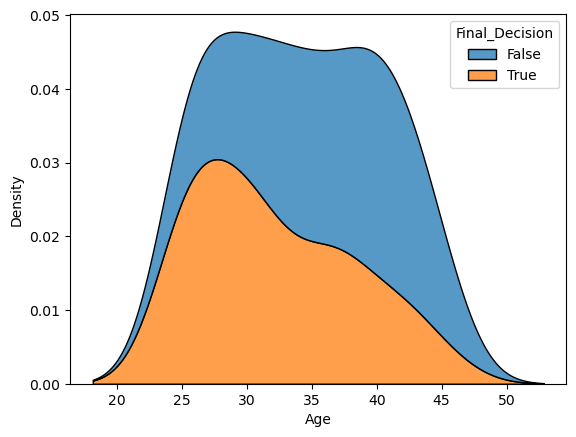

In [560]:
sns.kdeplot(data=new_applicants_BIAS, x="Age", hue="Final_Decision", multiple="stack")

<Axes: title={'center': 'HIL - Final Decision mean age \n(False = Rejected, True = Hired)'}, xlabel='Final_Decision'>

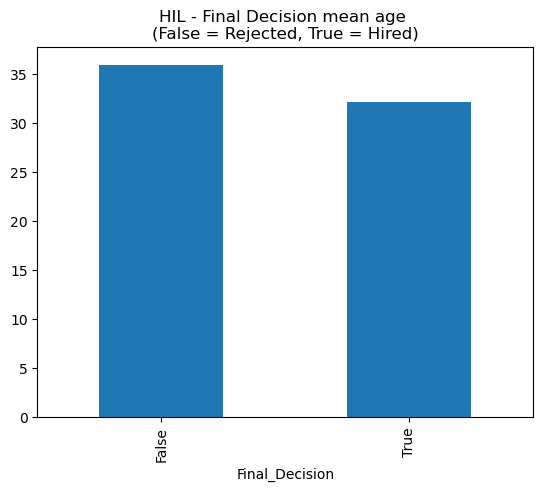

In [561]:
plt.title("HIL - Final Decision mean age \n(False = Rejected, True = Hired)")
new_applicants_BIAS.groupby('Final_Decision').Age.mean().plot.bar()